In [210]:
import pandas as pd
import numpy as np
from pandas.core.nanops import nancorr
import matplotlib.pyplot as plt
from generator import FactorGenerator as FG
import plotly

In [221]:
def IC(factor, cumulative=False):
    """
    Args:
        factor: Input factor data
        cumulative: Bool, return cumulative IC values or not.

    Returns: cross-sectional IC values, or cumulative cross-sectional IC values.
    """
    series = factor.shift(1).iloc[1:].apply(lambda row: nancorr(row, fg.rate.loc[row.name]), axis=1)
    return pd.DataFrame(series.cumsum(), columns=["IC"]) if cumulative else pd.DataFrame(series, columns=["IC"])


In [152]:
hs300 = pd.read_csv("data\\hs300.csv", encoding="utf-8-sig")
zz500 = pd.read_csv("data\\zz500.csv", encoding="utf-8-sig")
ri = pd.read_csv("data\\return.csv", encoding="utf-8-sig")
close = pd.read_csv("data\\close.csv", encoding="utf-8-sig")

assert ri["trade_date"].all() == hs300["trade_date"].all() == zz500["trade_date"].all() == close["trade_date"].all()
ri.set_index("trade_date", inplace=True)
hs300.set_index("trade_date", inplace=True)
zz500.set_index("trade_date", inplace=True)
close.set_index("trade_date", inplace=True)


In [122]:
def BIAS_n(n):
    bias = (close - close.shift(n)) / (100 * close.shift(n))
    bias = bias.apply(lambda row: row_normalize(row), axis=1)
    return bias

def row_normalize(row):
    return row / np.nansum(row) if np.nansum(row) != 0 else row / np.nan

def weighted_daily_return(row):
    return np.dot(row.fillna(0), ri.loc[row.name].fillna(0))

def IC(factor, R):
    return factor.apply(lambda col: nancorr(col, R), axis=0)

def top_correlated(factor, R, positive=True) -> pd.Series:
    IC_series = IC(factor=factor, R=R).dropna()
    return IC_series.sort_values(ascending=~positive).iloc[:10] if positive else IC_series.sort_values(ascending=positive).iloc[:10]

In [173]:
bias = BIAS_n(20)
daily_return = bias.apply(lambda row: weighted_daily_return(row), axis=1)
cumulative_return = pd.Series(np.nancumsum(daily_return), index=daily_return.index)

In [186]:
def factor_plot(series, description=None):
    traces = []

    # mode = "line",   line = dict(color = "blue")
    trace = plotly.graph_objs.Scattergl(
        x = series.index,
        y = series.values
    )

    traces.append(trace)

    if description:
        layout = plotly.graph_objs.Layout(
            title = description
        )
    else:
        layout = plotly.graph_objs.Layout(
            title = "Plot series data of: " + series.name
        )
    
    fig = plotly.graph_objs.Figure(data=traces, layout=layout)

    plotly.offline.init_notebook_mode(connected=True)
    return plotly.offline.iplot(fig, filename="dataplot")

In [201]:
close[["002077.SZ"]].iloc[:, 0].name

'002077.SZ'

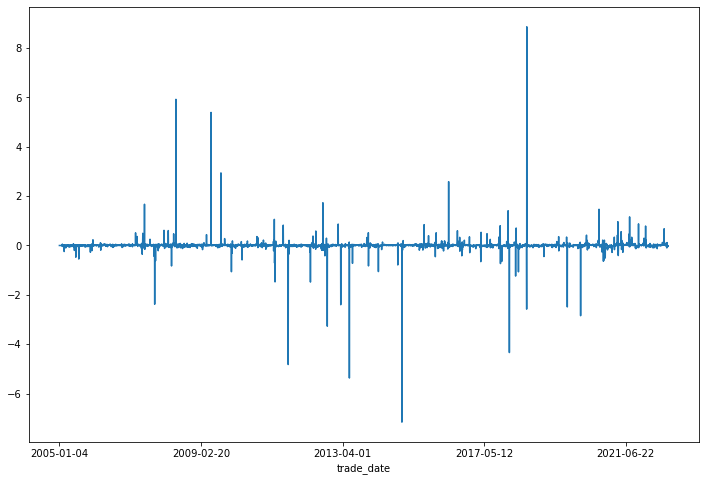

In [5]:
plt.figure(figsize=(12, 8))
daily_return.plot()
plt.show()

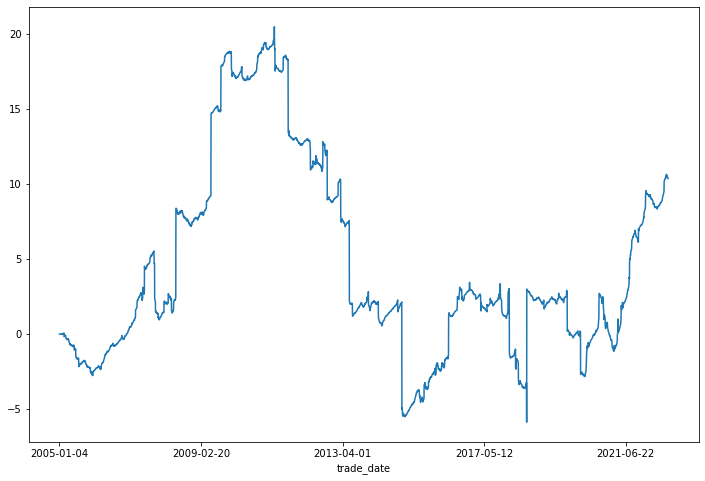

In [6]:
plt.figure(figsize=(12, 8))
cumulative_return.plot()
plt.show()

In [7]:
def BIAS_grid_search_para(arr):
    mean_return, optim_n = 0, None
    for n in arr:
        bias = BIAS_n(n)
        daily_return = bias.apply(lambda row: weighted_daily_return(row), axis=1)
        if np.nanmean(daily_return) > mean_return:
            mean_return, optim_n = np.nanmean(daily_return), n
    if not optim_n:
        return "Inefficient factor."
    return n, mean_return
        
optim_n, mean_return = BIAS_grid_search_para(range(1, 21))
print(f"The best parameter given by grid search is: {optim_n}" +\
      " with maximum cumulative return: {mean_return}")

The best parameter given by grid search is: 20 with maximum cumulative return: {mean_return}


In [8]:
optim_bias = BIAS_n(optim_n)
optim_daily_return = optim_bias.apply(lambda row: weighted_daily_return(row), 
                                      axis=1)
optim_cumulative_return = pd.Series(np.nancumsum(optim_daily_return), 
                                    index=optim_daily_return.index)

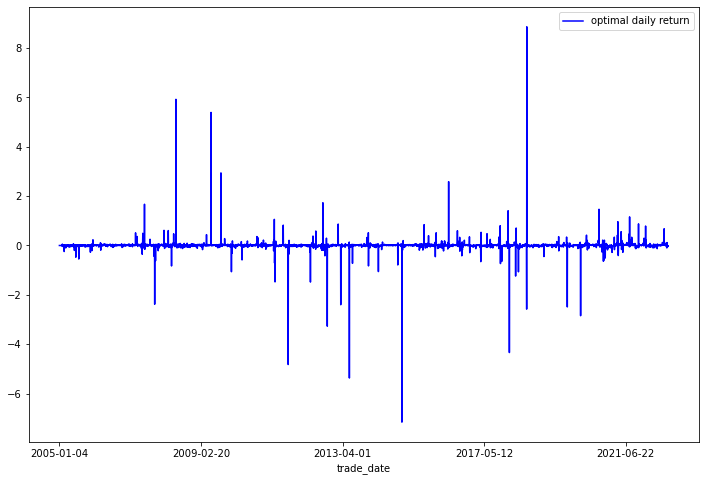

In [9]:
plt.figure(figsize=(12, 8))
optim_daily_return.plot(color="blue", label="optimal daily return")
plt.legend()
plt.show()

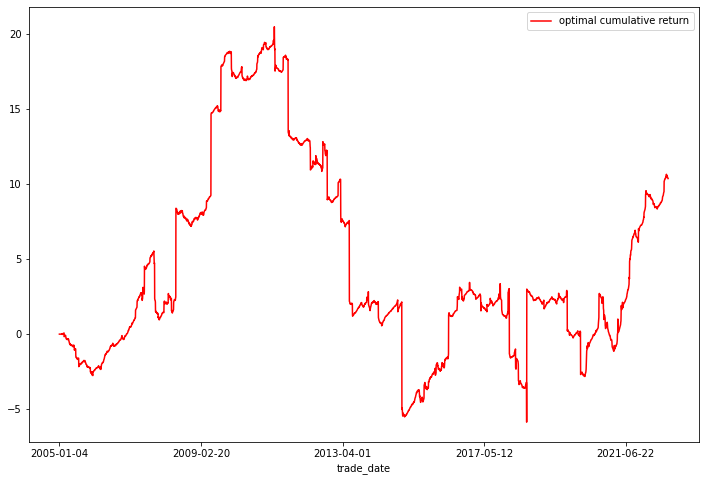

In [10]:
plt.figure(figsize=(12, 8))
optim_cumulative_return.plot(color="red", label="optimal cumulative return")
plt.legend()
plt.show()

In [ ]:
from FactorG